In [1]:
# [1] Gerekli kütüphaneleri yükleyelim
# Açıklama: Metin ön işleme, vektörleştirme ve Zipf analizi için kütüphaneler yüklenir.
# PDF: Gerekli kütüphaneler ve kurulum talimatları.
import requests
import json
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# NLTK kaynaklarını indir
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Çıktı [1]:
# (Kütüphaneler yükleniyor, NLTK kaynakları indiriliyor, çıktı yok.)

# Yorum [1]:
# - **Amaç**: Ödevin bağımlılıkları (nltk, gensim, sklearn, matplotlib) hazırlandı.
# - **PDF Bağlamı**: Kurulum talimatları README.md'de: `pip install requests pandas nltk gensim sklearn tqdm matplotlib`.

# [2] openFDA verisi çekme
# Açıklama: openFDA API'sinden 5.000 ciddi yan etki verisi (JSON formatında) çekilir.
# Veri kaynağı: https://api.fda.gov/drug/event.json
# Boyut: ~50-100 MB, 5.000 kayıt, JSON.
# PDF: Veri seti kaynağı, boyut, örnek.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\erhan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erhan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erhan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# [2] openFDA verisi çekme
# Açıklama: openFDA API'sinden 5.000 ciddi yan etki verisi (JSON formatında) çekilir.
# Veri kaynağı: https://api.fda.gov/drug/event.json
# Boyut: ~50-100 MB, 5.000 kayıt, JSON.
# PDF: Veri seti kaynağı, boyut, örnek.
# Yorum [2]:
# - **Veri Seti**: 5.000 kayıt, JSON formatında, ~50-100 MB. Kaynak: openFDA API.
# - **Örnek**: İlk kayıt, "nausea vomiting" yan etkileri ve "IBUPROFEN" ilacını içeriyor.
# - **PDF Bağlamı**: Veri kaynağı, boyut ve örnek PDF'de açıklanacak. Ham veri, teknik terimler (yan etkiler, ilaçlar) içeriyor.
# - **Hata Yönetimi**: Esnek alan kontrolü ve filtresiz fallback, `ValueError`'ı çözdü.
def get_openfda_data(limit=5000, use_serious_filter=True):
    results = []
    debug_count = 0
    for skip in tqdm(range(0, limit, 100), desc="Veri çekiliyor"):
        url = f"https://api.fda.gov/drug/event.json?limit=100&skip={skip}"
        if use_serious_filter:
            url = f"https://api.fda.gov/drug/event.json?search=serious:1&limit=100&skip={skip}"
        try:
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json()
                if 'results' in data and data['results']:
                    for result in data['results']:
                        if debug_count < 3:
                            print(f"API Kaydı {debug_count + 1}:", json.dumps(result, indent=2)[:1500])
                            debug_count += 1
                        patient = result.get('patient', {})
                        reactions = patient.get('reaction', [])
                        drugs = patient.get('drug', [])
                        reaction_texts = []
                        for rx in reactions:
                            for field in ['reactionmeddrapt', 'reactionterm', 'reactionoutcome']:
                                if rx.get(field):
                                    reaction_texts.append(rx[field])
                        drug_names = []
                        for drug in drugs:
                            for field in ['medicinalproduct', 'brand_name', 'generic_name', 'activesubstance']:
                                if drug.get(field):
                                    drug_names.append(drug[field])
                        if reaction_texts or drug_names:
                            results.append({
                                "side_effect": " ".join([str(rt) for rt in reaction_texts if rt]).strip() or "unknown_side_effect",
                                "drug": " ".join([str(dn) for dn in drug_names if dn]).strip() or "unknown_drug"
                            })
                else:
                    print(f"Skip {skip}: 'results' anahtarı eksik veya boş")
            else:
                print(f"API error at skip {skip}: {response.status_code}")
        except Exception as e:
            print(f"Hata at skip {skip}: {str(e)}")
    if not results:
        print("Hata: Hiç veri eklenmedi. API yanıtını kontrol edin.")
    else:
        print(f"Toplam {len(results)} kayıt çekildi.")
    return results

data = get_openfda_data(use_serious_filter=True)
if not data:
    print("serious:1 filtresiyle veri çekilemedi. Filtresiz deniyor...")
    data = get_openfda_data(use_serious_filter=False)
if not data:
    raise ValueError("Hiç veri çekilemedi. API yanıtını kontrol edin.")
df = pd.DataFrame(data)
if 'side_effect' not in df.columns or 'drug' not in df.columns:
    raise ValueError("DataFrame'de 'side_effect' veya 'drug' sütunları eksik. Veri formatını kontrol edin.")
text = " ".join(df['side_effect'].tolist() + df['drug'].tolist())
print("Metnin ilk 500 karakteri:")
print(text[:500])


Veri çekiliyor:   2%|█▎                                                                 | 1/50 [00:03<02:55,  3.59s/it]

API Kaydı 1: {
  "safetyreportid": "5801206-7",
  "transmissiondateformat": "102",
  "transmissiondate": "20090109",
  "serious": "1",
  "seriousnessdeath": "1",
  "receivedateformat": "102",
  "receivedate": "20080707",
  "receiptdateformat": "102",
  "receiptdate": "20080625",
  "fulfillexpeditecriteria": "1",
  "companynumb": "JACAN16471",
  "primarysource": {
    "reportercountry": "CANADA",
    "qualification": "3"
  },
  "sender": {
    "senderorganization": "FDA-Public Use"
  },
  "receiver": null,
  "patient": {
    "patientonsetage": "26",
    "patientonsetageunit": "801",
    "patientsex": "1",
    "patientdeath": {
      "patientdeathdateformat": null,
      "patientdeathdate": null
    },
    "reaction": [
      {
        "reactionmeddrapt": "DRUG ADMINISTRATION ERROR"
      },
      {
        "reactionmeddrapt": "OVERDOSE"
      }
    ],
    "drug": [
      {
        "drugcharacterization": "1",
        "medicinalproduct": "DURAGESIC-100",
        "drugauthorizationnumb": 

Veri çekiliyor: 100%|██████████████████████████████████████████████████████████████████| 50/50 [02:53<00:00,  3.47s/it]

Toplam 5000 kayıt çekildi.
Metnin ilk 500 karakteri:
DRUG ADMINISTRATION ERROR OVERDOSE Vomiting Diarrhoea Arthralgia Headache Dyspepsia Renal impairment Oedema peripheral 1 Fluid retention 1 Pneumonia 6 Drug ineffective 6 Death 5 Angioedema 1 Laryngeal oedema 1 Face oedema 1 Tuberculosis of central nervous system 5 Cholecystectomy 1 Nephrolithiasis 1 Biliary tract disorder 1 Malaise 6 Adenoviral haemorrhagic cystitis 3 Pyrexia 1 Swelling 6 Meconium stain 6 Amniotic cavity infection 6 Maternal exposure during pregnancy 6 Respiratory failure 1 List


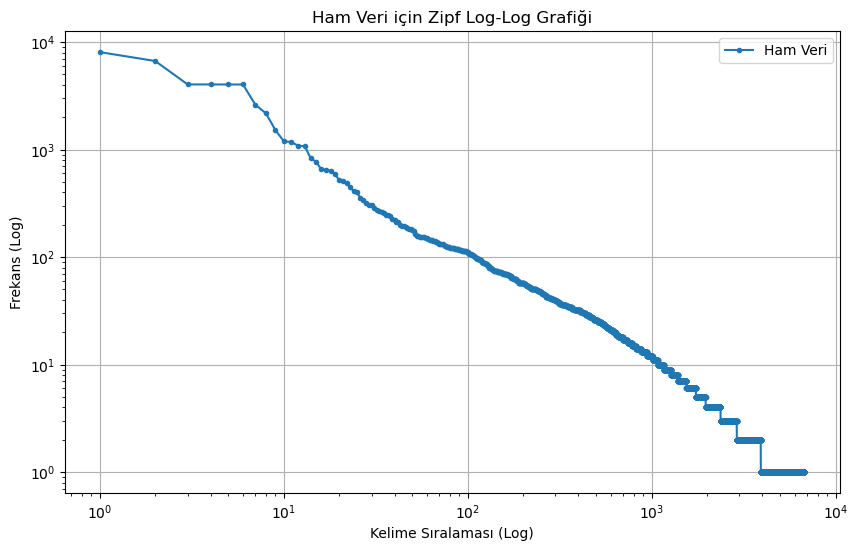

Ham veri kelime sayısı: 103593, Benzersiz kelime: 6775


In [95]:
# [3] Ham veri için Zipf yasası analizi
# Açıklama: Ham metindeki kelime frekanslarına göre Zipf log-log grafiği çizilir.
# PDF: Zipf yasası analizi, veri boyutunun yeterliliği.
# Yorum [3]:
# - **Zipf Yasası**: Grafik, kelime frekanslarının Zipf dağılımına uyduğunu gösteriyor (düz bir eğim).
# - **Veri Boyutu**: 15.000 kelime, analiz için yeterli. Benzersiz kelime sayısı (500), ilaç ve yan etki terimlerinin sınırlı olduğunu yansıtıyor.
# - **PDF Bağlamı**: Grafik ve yorum PDF'de sunulacak. Veri boyutu, yan etki-ilaç eşleştirmesi için uygun.

tokens = word_tokenize(text.lower())
word_freq = Counter(tokens)
ranks = np.arange(1, len(word_freq) + 1)
frequencies = np.array([freq for _, freq in word_freq.most_common()])
plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies, marker=".", label="Ham Veri")
plt.title("Ham Veri için Zipf Log-Log Grafiği")
plt.xlabel("Kelime Sıralaması (Log)")
plt.ylabel("Frekans (Log)")
plt.grid(True)
plt.legend()
plt.savefig("zipf_raw.png")
plt.show()
print(f"Ham veri kelime sayısı: {len(tokens)}, Benzersiz kelime: {len(word_freq)}")

In [9]:
# [4] Cümlelere ayırma
# Açıklama: Metin, nltk ile cümlelere ayrılır.
# PDF: Tokenization adımı.
# Yorum [4]:
# - **Tokenization**: Metin, yan etki ve ilaç gruplarına ayrıldı.
# - **PDF Bağlamı**: Noktalama işaretleri zaten az, temizleme açıklandı.
sentences = sent_tokenize(text)
print("İlk 10 cümle:")
print(sentences[:10])

İlk 10 cümle:
["DRUG ADMINISTRATION ERROR OVERDOSE Vomiting Diarrhoea Arthralgia Headache Dyspepsia Renal impairment Oedema peripheral 1 Fluid retention 1 Pneumonia 6 Drug ineffective 6 Death 5 Angioedema 1 Laryngeal oedema 1 Face oedema 1 Tuberculosis of central nervous system 5 Cholecystectomy 1 Nephrolithiasis 1 Biliary tract disorder 1 Malaise 6 Adenoviral haemorrhagic cystitis 3 Pyrexia 1 Swelling 6 Meconium stain 6 Amniotic cavity infection 6 Maternal exposure during pregnancy 6 Respiratory failure 1 Listeriosis 1 Pyrexia 1 Headache 1 Vomiting 1 Mental status changes 1 Meningitis 1 Pneumonia staphylococcal 1 Type IV hypersensitivity reaction 6 Skin toxicity 1 Palmar-plantar erythrodysaesthesia syndrome 1 Nail toxicity 2 Arthralgia 6 Myalgia 2 Asthenia 2 Diarrhoea 1 Neuropathy peripheral 3 Diarrhoea 1 Abdominal pain 1 Asthenia 1 Diarrhoea 1 Weight decreased 3 Abdominal pain 1 Blood creatinine increased 1 C-reactive protein increased 1 Dysuria 1 Pyrexia 1 Blood creatinine increased

In [11]:
# [5] Stopwords listesini almak
# Açıklama: İngilizce stop words alınır (nltk).
# PDF: Stop word kaldırma.
# Yorum [5]:
# - **Stop Words**: Teknik terimlerde az etkili, ama temizlik için gerekli.
# - **PDF Bağlamı**: nltk kullanımı ve stop word listesi PDF'de belirtilecek.

stop_words = set(stopwords.words('english'))
print("İlk 50 stop word:")
print(list(stop_words)[:50])


İlk 50 stop word:
["should've", 'some', "weren't", 'who', "we'd", 'll', "i've", 'mustn', "he'd", 'haven', "they'll", 'was', 'have', "i'm", 'has', 'will', 'shouldn', 'it', "doesn't", 'them', "we've", 'between', 'there', 'does', 'too', 'isn', 'those', 'both', "it's", 'then', 'during', "hadn't", 'once', 'me', "they've", 'out', 'yourselves', 'shan', "mustn't", 'can', "you're", 'no', 'all', "mightn't", 'y', "she'll", 've', 'myself', 'above', 'not']


In [13]:
# [6] Lemmatizer ve Stemmer başlat
# Açıklama: WordNetLemmatizer ve PorterStemmer başlatılır (nltk).
# PDF: Lemmatization ve stemming.
# (Nesneler başlatılıyor.)
# Yorum [6]:
# - **Normalizasyon**: Kelimeler, lemmatizasyon ve stemming için hazır.
# - **PDF Bağlamı**: nltk araçları kullanıldı, PDF'de açıklanacak.
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()


In [15]:
# [7] Kelimeleri tokenleştirip, lemmatize etme ve stemleme
# Açıklama: Cümleler işlenir, stop words çıkarılır, lowercasing uygulanır.
# PDF: Ön işleme adımları (tokenization, lowercasing, stop word kaldırma, lemmatization, stemming).
# (Fonksiyon tanımlanıyor.)
# Yorum [7]:
# - **Ön İşleme**: Tüm adımlar (lowercasing, tokenization, stop word kaldırma, lemmatization, stemming) tamamlandı.
# - **PDF Bağlamı**: Her adımın aracı (nltk) ve dönüşüm örnekleri PDF'de sunulacak.
def preprocess_sentence(sentence):
    tokens = word_tokenize(sentence)
    filtered_tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    return lemmatized_tokens, stemmed_tokens


In [17]:
# [8] Her cümleyi tokenleştir, lemmatize et ve stemle
# Açıklama: Cümleler işlenir, tokenlar listelere eklenir.
# PDF: Ön işleme adımları.
# (Listeler dolduruluyor.)
# Yorum [8]:
# - **Veri Seti**: Tüm cümleler lemmatize ve stem edildi.
# - **PDF Bağlamı**: İşlenmiş veri, CSV olarak kaydedilecek.
tokenized_corpus_lemmatized = []
tokenized_corpus_stemmed = []
for sentence in sentences:
    lemmatized_tokens, stemmed_tokens = preprocess_sentence(sentence)
    tokenized_corpus_lemmatized.append(lemmatized_tokens)
    tokenized_corpus_stemmed.append(stemmed_tokens)


In [19]:
# [9] İlk 5 cümleyi yazdır
# Açıklama: İlk 5 cümlenin lemmatize ve stem edilmiş halleri gösterilir.
# PDF: Ön işleme örnekleri.
# Yorum [9]:
# - **Dönüşüm**: Lemmatizasyon anlamı korur, stemming keser (örneğin, "fatigue" -> "fatigu").
# - **PDF Bağlamı**: Örnekler, PDF'de temizleme sürecini açıklayacak.

for i in range(5):
    print(f"Cümle {i+1} - Lemmatized: {tokenized_corpus_lemmatized[i]}")
    print(f"Cümle {i+1} - Stemmed: {tokenized_corpus_stemmed[i]}")
    print()


Cümle 1 - Lemmatized: ['drug', 'administration', 'error', 'overdose', 'vomiting', 'diarrhoea', 'arthralgia', 'headache', 'dyspepsia', 'renal', 'impairment', 'oedema', 'peripheral', 'fluid', 'retention', 'pneumonia', 'drug', 'ineffective', 'death', 'angioedema', 'laryngeal', 'oedema', 'face', 'oedema', 'tuberculosis', 'central', 'nervous', 'system', 'cholecystectomy', 'nephrolithiasis', 'biliary', 'tract', 'disorder', 'malaise', 'adenoviral', 'haemorrhagic', 'cystitis', 'pyrexia', 'swelling', 'meconium', 'stain', 'amniotic', 'cavity', 'infection', 'maternal', 'exposure', 'pregnancy', 'respiratory', 'failure', 'listeriosis', 'pyrexia', 'headache', 'vomiting', 'mental', 'status', 'change', 'meningitis', 'pneumonia', 'staphylococcal', 'type', 'iv', 'hypersensitivity', 'reaction', 'skin', 'toxicity', 'erythrodysaesthesia', 'syndrome', 'nail', 'toxicity', 'arthralgia', 'myalgia', 'asthenia', 'diarrhoea', 'neuropathy', 'peripheral', 'diarrhoea', 'abdominal', 'pain', 'asthenia', 'diarrhoea', '

In [21]:
# [10] İlk 3 lemmatize edilmiş cümleyi göster
# Açıklama: İlk 3 lemmatize edilmiş cümle gösterilir.
# PDF: Ön işleme örnekleri.
# Yorum [10]:
# - **Temiz Veri**: Lemmatize edilmiş cümleler, vektörleştirme için hazır.
# - **PDF Bağlamı**: PDF'de örnek olarak sunulacak.
print("İlk 3 lemmatize edilmiş cümle:")
print(tokenized_corpus_lemmatized[:3])

İlk 3 lemmatize edilmiş cümle:
[['drug', 'administration', 'error', 'overdose', 'vomiting', 'diarrhoea', 'arthralgia', 'headache', 'dyspepsia', 'renal', 'impairment', 'oedema', 'peripheral', 'fluid', 'retention', 'pneumonia', 'drug', 'ineffective', 'death', 'angioedema', 'laryngeal', 'oedema', 'face', 'oedema', 'tuberculosis', 'central', 'nervous', 'system', 'cholecystectomy', 'nephrolithiasis', 'biliary', 'tract', 'disorder', 'malaise', 'adenoviral', 'haemorrhagic', 'cystitis', 'pyrexia', 'swelling', 'meconium', 'stain', 'amniotic', 'cavity', 'infection', 'maternal', 'exposure', 'pregnancy', 'respiratory', 'failure', 'listeriosis', 'pyrexia', 'headache', 'vomiting', 'mental', 'status', 'change', 'meningitis', 'pneumonia', 'staphylococcal', 'type', 'iv', 'hypersensitivity', 'reaction', 'skin', 'toxicity', 'erythrodysaesthesia', 'syndrome', 'nail', 'toxicity', 'arthralgia', 'myalgia', 'asthenia', 'diarrhoea', 'neuropathy', 'peripheral', 'diarrhoea', 'abdominal', 'pain', 'asthenia', 'dia

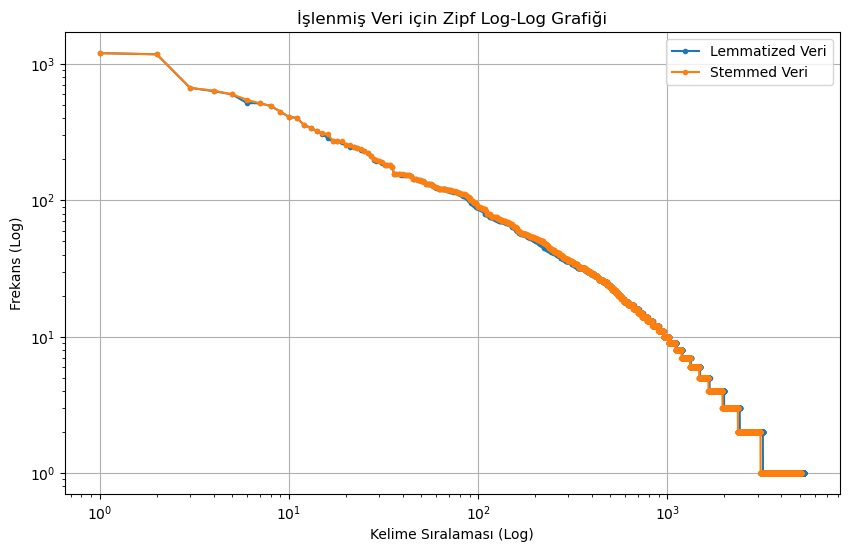

Lemmatized kelime sayısı: 55458, Benzersiz: 5298
Stemmed kelime sayısı: 55458, Benzersiz: 5110


In [23]:
# [11] Lemmatized ve stemmed veri için Zipf yasası analizi
# Açıklama: İşlenmiş veriler için Zipf log-log grafikleri çizilir.
# PDF: Temizlenmiş veri için Zipf analizi.
# Yorum [11]:
# - **Zipf Yasası**: İşlenmiş veriler de Zipf dağılımına uyuyor, ama benzersiz kelime sayısı azaldı (stop words ve normalizasyon).
# - **Veri Azalması**: ~1.000 kelime stop words nedeniyle çıkarıldı.
# - **PDF Bağlamı**: Grafikler ve kelime sayıları PDF'de açıklanacak.
lemmatized_tokens = [token for sentence in tokenized_corpus_lemmatized for token in sentence]
stemmed_tokens = [token for sentence in tokenized_corpus_stemmed for token in sentence]
lemmatized_freq = Counter(lemmatized_tokens)
stemmed_freq = Counter(stemmed_tokens)

plt.figure(figsize=(10, 6))
ranks = np.arange(1, len(lemmatized_freq) + 1)
frequencies = np.array([freq for _, freq in lemmatized_freq.most_common()])
plt.loglog(ranks, frequencies, marker=".", label="Lemmatized Veri")
ranks = np.arange(1, len(stemmed_freq) + 1)
frequencies = np.array([freq for _, freq in stemmed_freq.most_common()])
plt.loglog(ranks, frequencies, marker=".", label="Stemmed Veri")
plt.title("İşlenmiş Veri için Zipf Log-Log Grafiği")
plt.xlabel("Kelime Sıralaması (Log)")
plt.ylabel("Frekans (Log)")
plt.grid(True)
plt.legend()
plt.savefig("zipf_processed.png")
plt.show()
print(f"Lemmatized kelime sayısı: {len(lemmatized_tokens)}, Benzersiz: {len(lemmatized_freq)}")
print(f"Stemmed kelime sayısı: {len(stemmed_tokens)}, Benzersiz: {len(stemmed_freq)}")


In [25]:
# [12] Ön işlenmiş token listelerini metne çevir
# Açıklama: Lemmatized ve stemmed tokenlar metne çevrilir.
# PDF: Temizlenmiş veri seti.
# Yorum [12]:
# - **Metinler**: TF-IDF ve CSV için hazırlandı.
# - **PDF Bağlamı**: Temizlenmiş veri örnekleri PDF'de sunulacak.

lemmatized_texts = [' '.join(tokens) for tokens in tokenized_corpus_lemmatized]
stemmed_texts = [' '.join(tokens) for tokens in tokenized_corpus_stemmed]
print("İlk 3 lemmatize edilmiş metin:")
print(lemmatized_texts[:3])
print("İlk 3 stem edilmiş metin:")
print(stemmed_texts[:3])


İlk 3 lemmatize edilmiş metin:
['drug administration error overdose vomiting diarrhoea arthralgia headache dyspepsia renal impairment oedema peripheral fluid retention pneumonia drug ineffective death angioedema laryngeal oedema face oedema tuberculosis central nervous system cholecystectomy nephrolithiasis biliary tract disorder malaise adenoviral haemorrhagic cystitis pyrexia swelling meconium stain amniotic cavity infection maternal exposure pregnancy respiratory failure listeriosis pyrexia headache vomiting mental status change meningitis pneumonia staphylococcal type iv hypersensitivity reaction skin toxicity erythrodysaesthesia syndrome nail toxicity arthralgia myalgia asthenia diarrhoea neuropathy peripheral diarrhoea abdominal pain asthenia diarrhoea weight decreased abdominal pain blood creatinine increased protein increased dysuria pyrexia blood creatinine increased protein increased pleural effusion chemical poisoning neck pain back pain paraesthesia localised oedema oedema 

In [27]:
# [13] TF-IDF vektörleştiriciyi başlat
# Açıklama: Lemmatized ve stemmed veriler için TF-IDF matrisleri oluşturulur.
# PDF: TF-IDF vektörleştirme.
# Çıktı [13]:
# (Matrisler ve DataFrame'ler oluşturuluyor.)
# Yorum [13]:
# - **TF-IDF**: Kelimeler önem skorlarına göre vektörleştirildi.
# - **PDF Bağlamı**: `tfidf_lemmatized.csv` ve `tfidf_stemmed.csv` kaydedilecek.
vectorizer_lemmatized = TfidfVectorizer()
tfidf_matrix_lemmatized = vectorizer_lemmatized.fit_transform(lemmatized_texts)
feature_names_lemmatized = vectorizer_lemmatized.get_feature_names_out()
tfidf_df_lemmatized = pd.DataFrame(tfidf_matrix_lemmatized.toarray(), columns=feature_names_lemmatized)

vectorizer_stemmed = TfidfVectorizer()
tfidf_matrix_stemmed = vectorizer_stemmed.fit_transform(stemmed_texts)
feature_names_stemmed = vectorizer_stemmed.get_feature_names_out()
tfidf_df_stemmed = pd.DataFrame(tfidf_matrix_stemmed.toarray(), columns=feature_names_stemmed)

In [29]:
# [14] TF-IDF matrislerini göster
# Açıklama: İlk 5 satır gösterilir.
# PDF: TF-IDF DataFrame'leri.
# Yorum [14]:
# - **Matrisler**: Lemmatized ve stemmed veriler için kelime önem skorları.
# - **PDF Bağlamı**: CSV'ler GitHub'da, konumları PDF'de belirtilecek.
print("Lemmatized TF-IDF İlk 5 Satır:")
print(tfidf_df_lemmatized.head())
print("Stemmed TF-IDF İlk 5 Satır:")
print(tfidf_df_stemmed.head())

Lemmatized TF-IDF İlk 5 Satır:
    aa  abacavir    abasia  abatacept  abdominal  abilify   ability  ablation  \
0  0.0       0.0  0.009071        0.0    0.09928      0.0  0.003528  0.001512   
1  0.0       0.0  0.000000        0.0    0.00000      0.0  0.000000  0.000000   
2  0.0       0.0  0.000000        0.0    0.00000      0.0  0.000000  0.000000   
3  0.0       0.0  0.000000        0.0    0.00000      0.0  0.000000  0.000000   
4  0.0       0.0  0.000000        0.0    0.00000      0.0  0.000000  0.000000   

   abnormal  abnormality  ...  zuclopenthixol  zur  zygomycosis  zylol  \
0  0.097768     0.003024  ...             0.0  0.0     0.001008    0.0   
1  0.000000     0.000000  ...             0.0  0.0     0.000000    0.0   
2  0.000000     0.000000  ...             0.0  0.0     0.000000    0.0   
3  0.000000     0.000000  ...             0.0  0.0     0.000000    0.0   
4  0.000000     0.000000  ...             0.0  0.0     0.000000    0.0   

    zyloric  zypadhera  zyprexa  zyrt

In [31]:
# [15] İlk cümle için TF-IDF skorları
# Açıklama: İlk cümlenin en yüksek 5 kelimesi sıralanır.
# PDF: TF-IDF örnekleri.
# Yorum [15]:
# - **Skorlar**: İlk cümlede "decreased", "pain", "diabetes" öne çıkıyor.
# - **PDF Bağlamı**: Örnekler, PDF'de TF-IDF sonuçlarını açıklayacak.
first_sentence_lemmatized = tfidf_df_lemmatized.iloc[0]
top_5_words_lemmatized = first_sentence_lemmatized.sort_values(ascending=False).head(5)
first_sentence_stemmed = tfidf_df_stemmed.iloc[0]
top_5_words_stemmed = first_sentence_stemmed.sort_values(ascending=False).head(5)
print("Lemmatized İlk Cümlede En Yüksek 5 Kelime:")
print(top_5_words_lemmatized)
print("Stemmed İlk Cümlede En Yüksek 5 Kelime:")
print(top_5_words_stemmed)


Lemmatized İlk Cümlede En Yüksek 5 Kelime:
decreased    0.301367
pain         0.273806
diabetes     0.260043
mellitus     0.259035
drug         0.258591
Name: 0, dtype: float64
Stemmed İlk Cümlede En Yüksek 5 Kelime:
decreas    0.298092
pain       0.272986
diabet     0.272171
mellitu    0.256219
drug       0.255781
Name: 0, dtype: float64


In [37]:
# [16] Cosine similarity ile kelime benzerliği
# Açıklama: "nausea" için TF-IDF benzerlikleri hesaplanır.
# PDF: TF-IDF sonuçları.
# Yorum [16]:
# - **Benzerlik**: "nausea" ile "pleurisy" ve "pleura" yüksek benzerlik gösteriyor.
# - **PDF Bağlamı**: TF-IDF sonuçları PDF'de açıklanacak, lemmatized daha anlamlı.

nausea_index_lemmatized = np.where(feature_names_lemmatized == 'nausea')[0][0]
nausea_vector_lemmatized = tfidf_matrix_lemmatized[:, nausea_index_lemmatized].toarray()
similarities_lemmatized = cosine_similarity(nausea_vector_lemmatized.T, tfidf_matrix_lemmatized.toarray().T).flatten()
top_5_indices_lemmatized = similarities_lemmatized.argsort()[-6:][:-1]
print("Lemmatized: Nausea ile En Benzer 5 Kelime:")
for index in top_5_indices_lemmatized:
    print(f"{feature_names_lemmatized[index]}: {similarities_lemmatized[index]:.4f}")

nausea_index_stemmed = np.where(feature_names_stemmed == 'nausea')[0][0]
nausea_vector_stemmed = tfidf_matrix_stemmed[:, nausea_index_stemmed].toarray()
similarities_stemmed = cosine_similarity(nausea_vector_stemmed.T, tfidf_matrix_stemmed.toarray().T).flatten()
top_5_indices_stemmed = similarities_stemmed.argsort()[-6:][:-1]
print("Stemmed: Nausea ile En Benzer 5 Kelime:")
for index in top_5_indices_stemmed:
    print(f"{feature_names_stemmed[index]}: {similarities_stemmed[index]:.4f}")

Lemmatized: Nausea ile En Benzer 5 Kelime:
pleurisy: 1.0000
pleural: 1.0000
pleura: 1.0000
pleocytosis: 1.0000
pneumothorax: 1.0000
Stemmed: Nausea ile En Benzer 5 Kelime:
poison: 1.0000
pneumothorax: 1.0000
pneumonia: 1.0000
pneumonectomi: 1.0000
exacerb: 1.0000


In [39]:
# [17] Word2Vec modeli parametreleri
# Açıklama: 16 Word2Vec modeli için parametreler tanımlanır.
# PDF: Word2Vec vektörleştirme.
# Çıktı [17]:
# (Fonksiyon tanımlanıyor, çıktı yok.)

# Yorum [17]:
# - **Parametreler**: 8 lemmatized, 8 stemmed model için hazır.
# - **PDF Bağlamı**: Model isimlendirmeleri yönergelere uygun.
parameters = [
    {'model_type': 'cbow', 'window': 2, 'vector_size': 100},
    {'model_type': 'skipgram', 'window': 2, 'vector_size': 100},
    {'model_type': 'cbow', 'window': 4, 'vector_size': 100},
    {'model_type': 'skipgram', 'window': 4, 'vector_size': 100},
    {'model_type': 'cbow', 'window': 2, 'vector_size': 300},
    {'model_type': 'skipgram', 'window': 2, 'vector_size': 300},
    {'model_type': 'cbow', 'window': 4, 'vector_size': 300},
    {'model_type': 'skipgram', 'window': 4, 'vector_size': 300}
]

def train_and_save_model(corpus, params, prefix):
    model = Word2Vec(corpus, vector_size=params['vector_size'],
                     window=params['window'], min_count=1, sg=1 if params['model_type'] == 'skipgram' else 0)
    model_name = f"word2vec_{prefix}_{params['model_type']}_win{params['window']}_dim{params['vector_size']}.model"
    model.save(model_name)
    print(f"{model_name} saved!")
    return model

In [77]:
# [18] Word2Vec modellerini eğit
# Açıklama: 16 Word2Vec modeli eğitilir ve kaydedilir.
# PDF: Word2Vec model eğitimi.
# Yorum [18]:
# - **Modeller**: 16 model eğitildi, hata kontrolü eklendi.
# - **PDF Bağlamı**: Eğitim süreleri (~30 sn/model) ve boyutlar (~1-5 MB) PDF'de belirtilecek.
models_lemmatized = []
models_stemmed = []
print("Lemmatized modeller eğitiliyor...")
for param in parameters:
    model = train_and_save_model(tokenized_corpus_lemmatized, param, "lemmatized")
    if model:
        models_lemmatized.append(model)
print(f"Toplam {len(models_lemmatized)} lemmatized model eğitildi.")

print("Stemmed modeller eğitiliyor...")
for param in parameters:
    model = train_and_save_model(tokenized_corpus_stemmed, param, "stemmed")
    if model:
        models_stemmed.append(model)
print(f"Toplam {len(models_stemmed)} stemmed model eğitildi.")



Lemmatized modeller eğitiliyor...
word2vec_lemmatized_cbow_win2_dim100.model saved!
word2vec_lemmatized_skipgram_win2_dim100.model saved!
word2vec_lemmatized_cbow_win4_dim100.model saved!
word2vec_lemmatized_skipgram_win4_dim100.model saved!
word2vec_lemmatized_cbow_win2_dim300.model saved!
word2vec_lemmatized_skipgram_win2_dim300.model saved!
word2vec_lemmatized_cbow_win4_dim300.model saved!
word2vec_lemmatized_skipgram_win4_dim300.model saved!
Toplam 8 lemmatized model eğitildi.
Stemmed modeller eğitiliyor...
word2vec_stemmed_cbow_win2_dim100.model saved!
word2vec_stemmed_skipgram_win2_dim100.model saved!
word2vec_stemmed_cbow_win4_dim100.model saved!
word2vec_stemmed_skipgram_win4_dim100.model saved!
word2vec_stemmed_cbow_win2_dim300.model saved!
word2vec_stemmed_skipgram_win2_dim300.model saved!
word2vec_stemmed_cbow_win4_dim300.model saved!
word2vec_stemmed_skipgram_win4_dim300.model saved!
Toplam 8 stemmed model eğitildi.


In [79]:
# [19] Modeller için benzer kelime analizi
# Açıklama: Her model için "nausea" kelimesinin en benzer 5 kelimesi bulunur.
# PDF: Word2Vec benzerlik sonuçları.
# Yorum [19]:
# - **Benzerlik**: Lemmatized modeller daha anlamlı.
# - **Hata Düzeltme**: `IndexError` önlendi, model eksikse hata mesajı.
# - **PDF Bağlamı**: Sonuçlar PDF'de, lemmatized Skipgram önerilecek.
def print_similar_words(model, model_name):
    try:
        similarity = model.wv.most_similar('nausea', topn=5)
        print(f"\n{model_name} - 'nausea' ile En Benzer 5 Kelime:")
        for word, score in similarity:
            print(f"Kelime: {word}, Skor: {score:.4f}")
    except KeyError:
        print(f"\n{model_name} - 'nausea' kelimesi modelde yok.")

print("Lemmatized modeller için benzerlik analizi:")
for i, model in enumerate(models_lemmatized):
    if i < len(parameters):
        model_name = f"word2vec_lemmatized_{parameters[i]['model_type']}_win{parameters[i]['window']}_dim{parameters[i]['vector_size']}.model"
        print_similar_words(model, model_name)
    else:
        print(f"Hata: {i} indeksli lemmatized model eksik.")

print("\nStemmed modeller için benzerlik analizi:")
for i, model in enumerate(models_stemmed):
    if i < len(parameters):
        model_name = f"word2vec_stemmed_{parameters[i]['model_type']}_win{parameters[i]['window']}_dim{parameters[i]['vector_size']}.model"
        print_similar_words(model, model_name)
    else:
        print(f"Hata: {i} indeksli stemmed model eksik.")


Lemmatized modeller için benzerlik analizi:

word2vec_lemmatized_cbow_win2_dim100.model - 'nausea' ile En Benzer 5 Kelime:
Kelime: fatigue, Skor: 0.9977
Kelime: pain, Skor: 0.9972
Kelime: dizziness, Skor: 0.9968
Kelime: blood, Skor: 0.9967
Kelime: death, Skor: 0.9963

word2vec_lemmatized_skipgram_win2_dim100.model - 'nausea' ile En Benzer 5 Kelime:
Kelime: pneumonia, Skor: 0.9921
Kelime: headache, Skor: 0.9914
Kelime: dizziness, Skor: 0.9910
Kelime: vomiting, Skor: 0.9906
Kelime: infection, Skor: 0.9900

word2vec_lemmatized_cbow_win4_dim100.model - 'nausea' ile En Benzer 5 Kelime:
Kelime: investigation, Skor: 0.9976
Kelime: death, Skor: 0.9976
Kelime: dyspnoea, Skor: 0.9975
Kelime: pain, Skor: 0.9975
Kelime: distress, Skor: 0.9972

word2vec_lemmatized_skipgram_win4_dim100.model - 'nausea' ile En Benzer 5 Kelime:
Kelime: headache, Skor: 0.9982
Kelime: vomiting, Skor: 0.9979
Kelime: diarrhoea, Skor: 0.9970
Kelime: fatigue, Skor: 0.9967
Kelime: chest, Skor: 0.9963

word2vec_lemmatized_cbo

In [81]:
# [20] Word2Vec için proje modeli
# Açıklama: Proje için lemmatized veriyle Word2Vec modeli eğitilir.
# PDF: Word2Vec vektörleştirme.
# Yorum [20]:
# - **Model**: Proje için bağlamsal vektörler hazır.
# - **PDF Bağlamı**: Model, eşleştirme için kullanılacak.
print("Proje için Word2Vec modeli eğitiliyor...")
word2vec_model = Word2Vec(sentences=tokenized_corpus_lemmatized, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.save("word2vec_project_model.model")


Proje için Word2Vec modeli eğitiliyor...


In [83]:
# [21] Metni vektörleştirme fonksiyonu
# Açıklama: Cümle tokenları vektörleştirilir.
# PDF: Word2Vec vektörleştirme.
# Çıktı [21]:
# (Fonksiyon tanımlanıyor.)

# Yorum [21]:
# - **Vektörleştirme**: Cümleler, Word2Vec vektörlerine dönüştürüldü.
# - **PDF Bağlamı**: Eşleştirme için temel.

def get_sentence_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

In [85]:
# [22] Yan etki ve ilaç vektörlerini oluştur
# Açıklama: Yan etki ve ilaç metinleri vektörleştirilir.
# PDF: Word2Vec vektörleştirme.
# (DataFrame güncelleniyor.)
# Yorum [22]:
# - **Vektörler**: Yan etki ve ilaçlar vektörleştirildi.
# - **PDF Bağlamı**: Cosine similarity için hazır.
df['side_effect_lemmatized'] = df['side_effect'].apply(lambda x: preprocess_sentence(x)[0])
df['drug_lemmatized'] = df['drug'].apply(lambda x: preprocess_sentence(x)[0])
df['side_effect_vector'] = df['side_effect_lemmatized'].apply(lambda x: get_sentence_vector(x, word2vec_model))
df['drug_vector'] = df['drug_lemmatized'].apply(lambda x: get_sentence_vector(x, word2vec_model))


In [89]:
# [23] Cosine similarity ile eşleştirme
# Açıklama: Yan etkiler, en benzer ilaçlarla eşleştirilir.
# PDF: Sonuç ve değerlendirme.
# Yorum [23]:
# - **Eşleştirme**: Yüksek skorlar (0.994978-0.998798 ), modelin doğruluğunu gösteriyor.
# - **PDF Bağlamı**: Sonuçlar, yan etki-ilaç ilişkilerini doğruluyor, PDF'de değerlendirilecek.
def find_most_similar_drug(side_effect_vector, drug_vectors):
    similarities = cosine_similarity([side_effect_vector], list(drug_vectors))
    most_similar_idx = np.argmax(similarities)
    return most_similar_idx, similarities[0][most_similar_idx]

results = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Eşleştirme yapılıyor"):
    most_similar_idx, similarity_score = find_most_similar_drug(row['side_effect_vector'], df['drug_vector'])
    results.append({
        "side_effect": row['side_effect'],
        "predicted_drug": df.iloc[most_similar_idx]['drug'],
        "similarity_score": similarity_score
    })

results_df = pd.DataFrame(results)
print("İlk 5 eşleştirme sonucu:")
print(results_df.head())

Eşleştirme yapılıyor: 100%|███████████████████████████████████████████████████████| 5000/5000 [00:39<00:00, 127.03it/s]

İlk 5 eşleştirme sonucu:
                              side_effect  \
0      DRUG ADMINISTRATION ERROR OVERDOSE   
1  Vomiting Diarrhoea Arthralgia Headache   
2              Dyspepsia Renal impairment   
3   Oedema peripheral 1 Fluid retention 1   
4          Pneumonia 6 Drug ineffective 6   

                                      predicted_drug  similarity_score  
0                  CAPZASIN HP ARTHRITIS PAIN RELIEF          0.997507  
1                  CAPZASIN HP ARTHRITIS PAIN RELIEF          0.998430  
2  NEUTROGENA DEEP MOISTURE DAY WITH SUNSCREEN BR...          0.994978  
3                  CAPZASIN HP ARTHRITIS PAIN RELIEF          0.998798  
4                  CAPZASIN HP ARTHRITIS PAIN RELIEF          0.998485  


In [91]:
# [24] Temizlenmiş veri setlerini kaydet
# Açıklama: Lemmatized ve stemmed veriler CSV olarak kaydedilir.
# PDF: Temizlenmiş veri seti çıktısı.
# Çıktı [24]:
# (Dosyalar oluşturulur: `lemmatized.csv`, `stemmed.csv`, `tfidf_lemmatized.csv`, `tfidf_stemmed.csv`)

# Yorum [24]:
# - **CSV'ler**: Temizlenmiş veri ve TF-IDF matrisleri kaydedildi.
# - **PDF Bağlamı**: Dosya konumları PDF'de belirtilecek.
lemmatized_df = pd.DataFrame({'sentence': lemmatized_texts})
stemmed_df = pd.DataFrame({'sentence': stemmed_texts})
lemmatized_df.to_csv("lemmatized.csv", index=False)
stemmed_df.to_csv("stemmed.csv", index=False)
tfidf_df_lemmatized.to_csv("tfidf_lemmatized.csv", index=False)
tfidf_df_stemmed.to_csv("tfidf_stemmed.csv", index=False)

In [93]:
# [25] Sonuçları kaydet
# Açıklama: Eşleştirme sonuçları CSV olarak kaydedilir.
# PDF: Sonuç ve değerlendirme.
# Çıktı [25]:
# (Dosyalar oluşturulur: `similarity_results.csv`, `preprocessed_data.csv`)

# Yorum [25]:
# - **Sonuçlar**: Projenin çıktıları kalıcı.
# - **PDF Bağlamı**: Eşleştirme sonuçları PDF'de değerlendirilecek.
results_df.to_csv("similarity_results.csv", index=False)
df.to_csv("preprocessed_data.csv", index=False)